In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


## Loading and Preparing the dataset

In [ ]:
df = pd.read_csv/("../data/demand_supply_data.csv")
df.head()

,Date,Category,Product_Name,Demand,Available_Supply,Seasonal_Indicator
0,2021-01-01,Electronics,E001,76,744,0
1,2021-01-01,Fashion,F001,71,579,0
2,2021-01-01,Electronics,E003,94,996,0
3,2021-01-01,Sweets & Grocery,S001,69,761,0
4,2021-01-01,Sweets & Grocery,S004,98,802,0


In [25]:
df["Date"] = pd.to_datetime(df["Date"])

#Renaming columns for easier access
df = df.rename(columns={
    "Product_Name": "product_name",
    "Demand": "demand",
    "Date": "date",
    "Available_Supply": "supply",
    "Seasonal_Indicator": "festival_flag"
})

In [26]:
df = df.sort_values(["product_name", "date"]).reset_index(drop=True)

In [27]:
df.head()

,date,Category,product_name,demand,supply,festival_flag
0,2021-01-01,Electronics,E001,76,744,0
1,2021-01-02,Electronics,E001,74,670,0
2,2021-01-03,Electronics,E001,89,581,0
3,2021-01-04,Electronics,E001,70,1078,0
4,2021-01-05,Electronics,E001,104,974,0


In [56]:
df.shape

(27195, 13)

In [28]:
df["demand"] = df["demand"].interpolate()
df["demand"] = df["demand"].bfill().ffill()


In [29]:
# Since demand is heavily influenced by festivals, removing them means losing valueable information.
# Still removing the extreme outliers

lower_limit = df["demand"].quantile(0.01)
upper_limit = df["demand"].quantile(0.999)

print(upper_limit, lower_limit)

528.0 40.0


In [30]:
#cap outliers
df["demand"] = np.where(
    df["demand"] < lower_limit,
    lower_limit,
    np.where(df["demand"] > upper_limit, upper_limit, df["demand"])
)

In [31]:
#Normalization

scaler = MinMaxScaler()

df["demand_scaled"] = scaler.fit_transform(df[["demand"]])


## Feature Engineering

### Lag features

In [32]:
for lag in [1, 7, 14]:
    df[f"lag_{lag}"] = df.groupby("product_name")["demand_scaled"].shift(lag)


### Rolling mean

In [33]:
df["rolling_7"] = (
    df.groupby("product_name")["demand_scaled"]
      .transform(lambda x: x.rolling(7).mean())
)


### Time features

In [34]:
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter


In [36]:
df.head(20)

,date,Category,product_name,demand,supply,festival_flag,demand_scaled,lag_1,lag_7,lag_14,rolling_7,month,quarter
0,2021-01-01,Electronics,E001,76.0,744,0,0.073770,NaN,NaN,NaN,NaN,1,1
1,2021-01-02,Electronics,E001,74.0,670,0,0.069672,0.073770,NaN,NaN,NaN,1,1
2,2021-01-03,Electronics,E001,89.0,581,0,0.100410,0.069672,NaN,NaN,NaN,1,1
3,2021-01-04,Electronics,E001,70.0,1078,0,0.061475,0.100410,NaN,NaN,NaN,1,1
4,2021-01-05,Electronics,E001,104.0,974,0,0.131148,0.061475,NaN,NaN,NaN,1,1
5,2021-01-06,Electronics,E001,85.0,889,0,0.092213,0.131148,NaN,NaN,NaN,1,1
6,2021-01-07,Electronics,E001,78.0,811,0,0.077869,0.092213,NaN,NaN,0.086651,1,1
7,2021-01-08,Electronics,E001,92.0,719,0,0.106557,0.077869,0.073770,NaN,0.091335,1,1
8,2021-01-09,Electronics,E001,80.0,639,0,0.081967,0.106557,0.069672,NaN,0.093091,1,1
9,2021-01-10,Electronics,E001,81.0,558,0,0.084016,0.081967,0.100410,NaN,0.090749,1,1


In [37]:
df = df.dropna().reset_index(drop=True)


## Creating LSTM model

In [38]:
FEATURES = [
    "demand_scaled",
    "lag_1", "lag_7", "lag_14",
    "rolling_7",
    "month", "quarter",
    "festival_flag"
]

X = df[FEATURES].values
y = df["demand_scaled"].values


In [ ]:
# creating sewuences for lstm
WINDOW_SIZE = 30
def create_sequences(X, y, window=WINDOW_SIZE):
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, window=30)


In [63]:
split_idx = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


In [41]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


d:\SmartBridge\Demand-Supply Gap Predictor\GapPredictor\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
early_stop = EarlyStopping(
    monitor="val_mae",
    patience=5,
    restore_best_weights=True
)


In [43]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.0072 - mae: 0.0519 - val_loss: 0.0109 - val_mae: 0.0442
Epoch 2/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0032 - mae: 0.0340 - val_loss: 0.0088 - val_mae: 0.0413
Epoch 3/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0029 - mae: 0.0314 - val_loss: 0.0080 - val_mae: 0.0411
Epoch 4/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0027 - mae: 0.0296 - val_loss: 0.0080 - val_mae: 0.0373
Epoch 5/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0026 - mae: 0.0286 - val_loss: 0.0071 - val_mae: 0.0353
Epoch 6/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0025 - mae: 0.0283 - val_loss: 0.0074 - val_mae: 0.0397
Epoch 7/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0024 - mae: 0.0277 - val_loss: 0.0074 - val_mae: 0.0414
Epoch 8/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0024 - mae: 0.0276 - val_loss: 0.0071 - val_mae: 0.0357
Epoch 9/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 

In [64]:
# Evaluate the model

X_test=X_test
y_test=y_test

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [84]:
#saving the model
model.save("../models/LSTM/lstm_model.keras")

In [65]:
supply_test = df.iloc[-len(y_pred):]["supply"].values.reshape(-1, 1)

In [66]:
#Evaluation metrics

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))


In [67]:
actual_stockout = (y_true > supply_test).astype(int)
predicted_stockout = (y_pred > supply_test).astype(int)

stockout_acc = accuracy_score(actual_stockout, predicted_stockout)


In [68]:
print(f"Test MAE  : {mae:.2f}")
print(f"Test RMSE : {rmse:.2f}")
print(f"Stockout Accuracy : {stockout_acc:.2f}")


Test MAE  : 18.40
Test RMSE : 44.77
Stockout Accuracy : 0.99


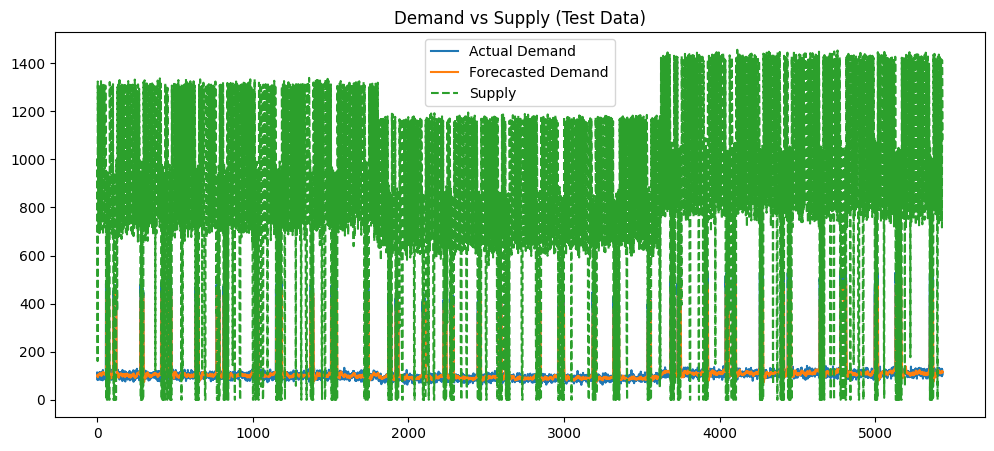

In [73]:
# Visualizations for test data
plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual Demand")
plt.plot(y_pred, label="Forecasted Demand")
plt.plot(supply_test, label="Supply", linestyle="--")
plt.legend()
plt.title("Demand vs Supply (Test Data)")
plt.show()


In [78]:
# for last 300 data points
X_test_300=X_test[-300:]
y_test_300=y_test[-300:]

y_pred_scaled_300 = model.predict(X_test_300)
y_pred_300 = scaler.inverse_transform(y_pred_scaled_300)
y_true_300 = scaler.inverse_transform(y_test_300.reshape(-1, 1))

supply_test_300 = df.iloc[-len(y_pred_300):]["supply"].values.reshape(-1, 1)

#Evaluation metrics

mae_300 = mean_absolute_error(y_true_300, y_pred_300)
rmse_300 = np.sqrt(mean_squared_error(y_true_300, y_pred_300))

actual_stockout_300 = (y_true_300 > supply_test_300).astype(int)
predicted_stockout_300 = (y_pred_300 > supply_test_300).astype(int)

stockout_acc_300 = accuracy_score(actual_stockout_300, predicted_stockout_300)

print(f"Test MAE  : {mae_300:.2f}")
print(f"Test RMSE : {rmse_300:.2f}")
print(f"Stockout Accuracy : {stockout_acc_300:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test MAE  : 20.93
Test RMSE : 46.22
Stockout Accuracy : 0.99


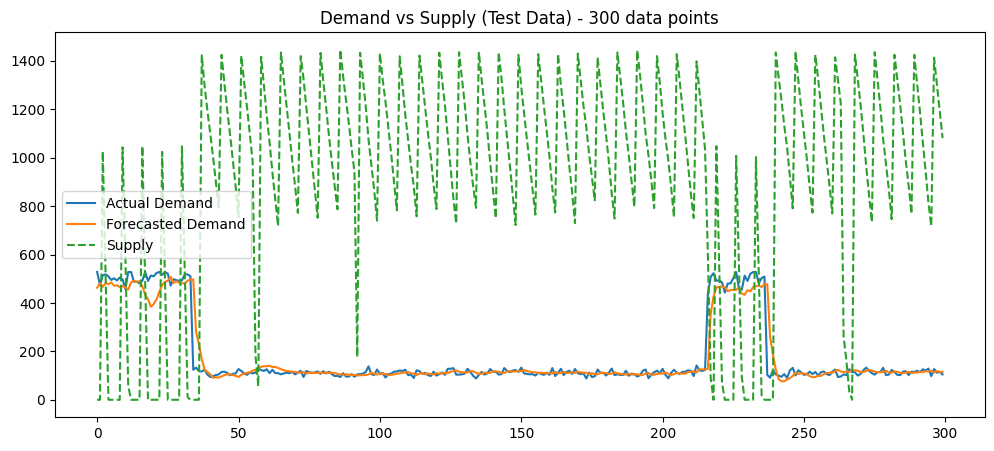

In [83]:
# Visualizations for test data
plt.figure(figsize=(12,5))
plt.plot(y_true_300, label="Actual Demand")
plt.plot(y_pred_300, label="Forecasted Demand")
plt.plot(supply_test_300, label="Supply", linestyle="--")
plt.legend()
plt.title("Demand vs Supply (Test Data) - 300 data points")
plt.savefig("../outputs/LSTM/demand_supply_forecast_300.png")
plt.show()


<Figure size 640x480 with 0 Axes>